# 라이브러리 import

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
# 이부분은 보류

# settings
import warnings
warnings.filterwarnings('ignore')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 6  # matlab 차트의 기본 크기를 지정

# 데이터 준비

## 데이터 불러오기

In [14]:
cats=pd.read_csv('data/item_categories.csv')
item = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')

train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


## 이상치 탐색

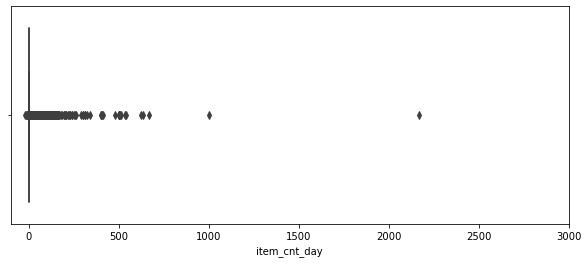

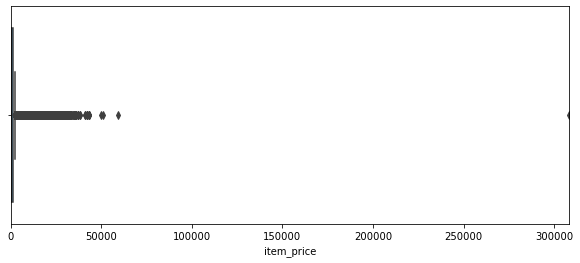

2935849
2
12
1
2935846


In [5]:
plt.figure(figsize = (10,4))
plt.xlim(-100, 3000)
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,4) )
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot( x = train.item_price )
plt.show()

print('이상치 제거 전 : ', train.shape[0])
print('item_cnt_day값이 999보다 큰 값 : ',len(train[train.item_cnt_day >999]),'개')
print('item_cnt_dat > 500 : ',len(train[ train.item_cnt_day > 500]),'개' )
print('item_price>100000 : ', len(train[train.item_price >100000 ]), '객')
train = train[(train.item_price < 100000 )& (train.item_cnt_day < 1000)]
print('이상치 제거 후 : ', train.shape[0])

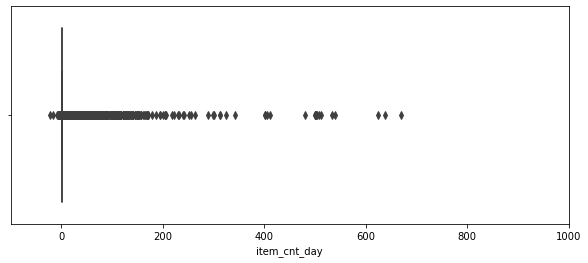

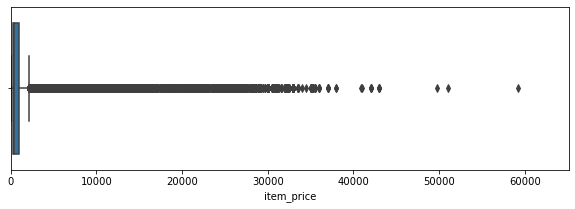

In [6]:
plt.figure(figsize = (10,4))
plt.xlim( -100, 1000 )
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,3) )
plt.xlim( train.item_price.min(), train.item_price.max()*1.1 )
sns.boxplot( x = train.item_price )
plt.show()

In [7]:
# train data에서 가격이 음수인 경우를 제외
# 물건 개수가 1개 이하인 경우 다 0으로 변경
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0


## Shop이름 전처리
- 러시아어지만 자세히 보면 이름이 같다.
  
  
1. ```0 == 57```
2. ```1 == 58```
3. ```11 == 10```
4. ```40 == 39```

---

- ```shop_name```에서 두가지 정보를 추출
    1. ```city```
    2. ```category```
        - ```LabelEncoder```활용 
        - Categorical -> Numeric
---


In [8]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [9]:
train.loc[train.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
train.loc[train.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

In [10]:
# 공백이 있던 가게 이름을 공백 제거
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'

# shop이름의 앞부분은 도시를 뜻한다. => shops에 city 컬럼 생성
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
# 뒷 부분은 category => shops에 category 컬럼 생성
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )

# 이름 앞부분에 느낌표 제거
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [11]:
#4개 이상있는 카테고리에 대해서 category리스트에 저장
category = []
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )
    if len(shops[shops.category == cat]) > 4:
        category.append(cat)

Орджоникидзе, 2
ТЦ 28
ТРК 5
ТРЦ 11
(Плехановская, 1
Торговля 1
ул. 2
ЧС 1
"Распродажа" 1
МТРЦ 1
Магазин 1
ТК 5
склад 1


In [12]:
# category외에 나머지는 etc로 적용
shops.category = shops.category.apply( lambda x: x if (x in category) else "etc" )

In [13]:
# category확인
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )

etc 11
ТЦ 28
ТРК 5
ТРЦ 11
ТК 5


In [14]:
# Categorical한 것을 Numeric하게 수치화
# shop_ 을 접두어로 새로운 컬럼 생성
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )

In [15]:
shops = shops[["shop_id", "shop_category", "shop_city"]]

## item_categories 전처리
- ```item_category_name```에서 물품의 ```type_code``` 추출
    - 러시아어 처리
- 위에서 사용했던 category만드는 방식을 똑같이 사용
    - 4개 이상만 저장, 나머지 category는 etc
- ```LabelEncoder```활용

In [16]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [17]:
cats.shape

(84, 4)

In [18]:
category = []
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))
    if len(cats[cats.type_code == cat]) > 4: 
        category.append( cat )

PC 1
Аксессуары 7
Билеты 1
Доставка 1
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6
Служебные 2
Чистые 2
Элементы 1


In [19]:
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [20]:
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))

etc 8
Аксессуары 7
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6


In [21]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

In [22]:
cats.head()

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1


## items 전처리
- 정규표현식을 활용해서 전처리
- ```item_id```의 개수가 40개 이하일 경우 'etc'로 처리
- ```LabelEncoder```사용

In [23]:
import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [24]:
items = item

items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

In [25]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [26]:
# type으로 그룹화 및 item_id를 Count
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
print( group_sum.reset_index() )
group_sum = group_sum.reset_index()

        type  item_id
0          0    17661
1        5c5        1
2        5c7        2
3        5f4        1
4        6dv        1
5        6jv        1
6        6l6        1
7    android        3
8        hm3        1
9        j72        4
10       kf6        1
11       kf7        1
12       kg4        1
13       mac       43
14        pc     2628
15        ps       79
16       ps2        2
17       ps3      611
18       ps4      174
19       psp      115
20       s3v        1
21       s4v        1
22   xbox360      466
23   xboxone      123
24      англ        1
25        рс       14
26   русская        1
27    только        9
28     цифро        1
29  цифровая      222


In [27]:
# 지울 컬럼명들을 따로 저장시킨다
# item_id별로 개수가 40개 이하인 경우 없앤다.
drop_cols = []
for cat in group_sum.type.unique():
#     print(group_sum.loc[(group_sum.type == cat), "item_id"].values[0])
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)

In [28]:
drop_cols

['5c5',
 '5c7',
 '5f4',
 '6dv',
 '6jv',
 '6l6',
 'android',
 'hm3',
 'j72',
 'kf6',
 'kf7',
 'kg4',
 'ps2',
 's3v',
 's4v',
 'англ',
 'рс',
 'русская',
 'только',
 'цифро']

In [29]:
items.head()

,item_name,item_id,item_category_id,name1,name2,name3,type
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d,0
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0,pc
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d,0
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d,0
4,коробка,4,40,***КОРОБКА,0,стекло d,0


In [30]:
# 'name2'에서 drop_cols에 있다면 (40개 이하라면) etc로 적용
items.name2 = items.name2.apply( lambda x: "etc" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [31]:
# LabelEncoder사용
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


## Feature Engineering
- ```matrix``` 생성
    - ```shop_id```, ```item_id```를 활용해서 모든 조합을 생성
    - ```sales```에서 ```data_block_num```, ```shop_id```, ```item_id``` 컬럼을 가져옴

In [32]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

6.124908924102783

### ```revenue```  생성

In [ ]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

### ```item_cnt_month``` 생성 (label값)
- ```date_block_num```, ```shop_id```, ```item_id``` <-> ```item_cnt_day```의 합

In [34]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)
time.time() - ts

2.467829942703247

- 월 별로 늘어나는 숫자 ```date_block_num```
- 주어진 데이터에는 0~33까지 총 34달치의 데이터가 있고 예측해야 할 35번째 달을 ```test```데이터의 ```date_block_num```에 저장한다.

In [35]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

- 그리고 test의 데이터 또한 matrix에 같이 합쳐준다

In [36]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.033342838287353516

###  dataframe 합치기
- 앞에서 전처리한 ```shops```, ```items```, ```cats```들을 matrix에 합쳐준다

In [37]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

2.0793914794921875

- ```lag_feature```함수
    - 입력인자 : df(dateframe), lags(list), cols(df에 있는 컬럼명)
    - 출력인자 : df(dataframe)
    - 입력받은 df에서 원하는 col명에 대해 lags만큼 시간적으로 뒤의 데이터들로 새로운 컬럼(feature)을 생성한다.

In [38]:
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

### item_cnt_month 생성
- lags = 1, 2, 3

In [39]:
ts = time.time()

matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


9.691984415054321

### date_avg_item_cnt 생성
- date_block_num -> item_cnt_month의 평균
- lags = 1

In [40]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


5.177298069000244

### date_item_avg_item_cnt 생성
- date_block_num, item_id -> item_cnt_month의 평균
- lags = 1, 2, 3

In [41]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


12.1839017868042

### date_item_avg_item_cnt 생성
- date_block_num, item_id -> item_cnt_month의 평균
- lags = 1, 2, 3

In [42]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


12.527455806732178

### date_shop_avg_item_cnt 생성
- date_block_num, shop_id -> item_cnt_month의 평균
- lags = 1, 2, 3

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

### date_shop_item_avg_item_cnt 생성
- date_block_num, shop_id, item_id -> item_cnt_month의 평균
- lags = 1, 2, 3

In [44]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_shop_item_avg_item_cnt


17.913346529006958

### date_shop_subtype_avg_item_cnt
- date_block_num, shop_id, subtype_code -> item_cnt_month의 평균
- lags = 1

In [45]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


6.8460822105407715

### date_city_avg_item_cnt
- date_block_num, shop_city -> item_cnt_month의 평균
- lags = 1

In [46]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


6.779589653015137

### date_item_city_avg_item_cnt
- date_block_num, item_id, shop_city -> item_cnt_month의 평균
- lags = 1

In [47]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


10.467924356460571

### ```delta_price_lag``` 생성
- 여기서는 조금 다르다.
- (```item_id``` -> ```item_price```의 평균), (```date_block_num```, ```item_id``` -> ```item_price```의 평균) 활용
- ```lags = 1, 2, 3```,  ```select_trend```함수를 선언, ```delta_price_lag_i(1, 2, 3)```중에서 한가지의 trend만 선택 => ```delta_price_lag```

In [48]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


189.49690198898315

### ```delta_revenue_lag_1``` 생성
- ```date_block_num```, shop_id``` -> ```revenue```의 합
    - ```date_shop_revenue``` 생성
- ```shop_id``` -> ```date_block_num```의 평균
    - ```shop_avg_revenue``` 생성
- ```date_shop_revenue```, ```shop_avg_revenue``` 활용
    - ```delta_revenue``` 생성
- ```delta_revenue``` + ```lag_feature``` (lag=1)
    - ```delta_revenue_lag_1``` 생성

In [49]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


7.761152505874634

In [50]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,4,0,40,4,42,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,2,27,1.0,4,0,19,76,42,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0,2,28,0.0,4,0,30,107,42,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0,2,29,0.0,4,0,23,123,42,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0,2,32,0.0,4,0,40,4,42,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,45,18454,0.0,4,20,55,4,42,2,...,0.129395,0.13916,1.0,0.0,0.0,0.126831,0.135376,0.5,-0.475098,51790.574219
11056273,34,45,16188,0.0,4,20,64,4,42,42,...,0.129395,NaN,0.0,0.0,NaN,0.094482,0.135376,0.0,0.081116,51790.574219
11056274,34,45,15757,0.0,4,20,55,4,42,2,...,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.135376,0.0,0.155884,51790.574219
11056275,34,45,19648,0.0,4,20,40,4,1367,4,...,0.129395,0.13916,0.0,0.0,0.0,0.083740,0.135376,0.0,-0.091736,51790.574219


### ```month``` 생성
- date_block_num 활용

In [52]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])

### ```item_shop_first_sale```, ```item_first_sale``` 생성

In [53]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

0.9838986396789551

In [54]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.5415735244750977

## 데이터 저장

In [55]:
matrix.to_pickle('data.pkl')

# 모델 생성 및 학습

## 라이브러리 import

In [1]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

## 데이터 로드

In [2]:
data = pd.read_pickle('data.pkl')

In [3]:
data[data["date_block_num"]==34].shape

(214200, 35)

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
X_test.shape

(214200, 34)

In [7]:
del data
gc.collect();

## 학습
1. XGBoost
2. LGBM
3. LGBM 앙상블

In [8]:
from tqdm.notebook import tqdm

In [ ]:
ts = time.time()

# XGB
# model = XGBRegressor(
#     max_depth=13,
#     n_estimators=900,
#     min_child_weight=0.5, 
#     colsample_bytree=0.7, 
#     subsample=0.8, 
#     eta=0.1,
# #     tree_method='gpu_hist',
#     seed=42)

# LGBM
# model = LGBMRegressor(
#     learning_rate = 0.08,
#     num_leaves= 4000,
#     n_estimators=300,        # no
#     max_depth=-1,
#     min_child_weight= 3,     # no
#     subsample= 0.8,
#     colsample_bytree= 0.4,
#     n_jobs= -1,
#     reg_lambda=0.8
#     # lambda = 0.7
# )

# LGBM 앙상블
param = {
    'learning_rate' : 0.08,
    'num_leaves': 4000,
    'n_estimators':300,        # no
    'max_depth':-1,
    'min_child_weight': 3,     # no
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'n_jobs': -1,
#     reg_lambda=0.8
    'lambda' : 0.8
}

# model = LGBMRegressor(
#     learning_rate = 0.11,
#     num_leaves= 400,
#     n_estimators=300,        # no
#     max_depth=-1,
#     min_child_weight= 3,     # no
#     subsample= 0.8,
#     colsample_bytree= 0.5,
#     n_jobs= -1,
#     reg_lambda=0.7
#     # lambda = 0.7
# )


# XGB, LGBM사용할 때
# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True,
#     early_stopping_rounds = 50)

# LGBM 앙상블 (range안에 횟수를 조절)
tmp = []
for _ in tqdm(range(30)) :
    data_index = [idx for idx in range(X_train.shape[0])]
    random_index = np.random.choice(data_index, X_train.shape[0])
    lgb_data = lgb.Dataset(data=X_train.iloc[random_index,], label=Y_train.iloc[random_index,])
    lgb_val = lgb.Dataset(data=X_valid, label=Y_valid)
    lgb_model = lgb.train(params=param, train_set=lgb_data, valid_sets=lgb_val)
    predict = lgb_model.predict(X_test)
    tmp.append(predict)

time.time() - ts

### XGBoost, LGBM 사용시 예측값 결과물로 만들기

In [89]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('lgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

### LGBM 앙상블 예측값 만들기
- 각 예측값들의 평균을 사용

In [ ]:
predictions = []
for idx2 in tqdm(range(X_test.shape[0])):
    temp = []
    for idx in range(len(tmp)):
        temp.append(tmp[idx][idx2])
    predictions.append(np.mean(temp))

In [ ]:
len(predictions), test.shape

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": predictions
})
submission.to_csv('lgb_ensemble.csv', index=False)

### ```xgboost```, ```plot_importance```

ValueError: tree must be Booster, XGBModel or dict instance

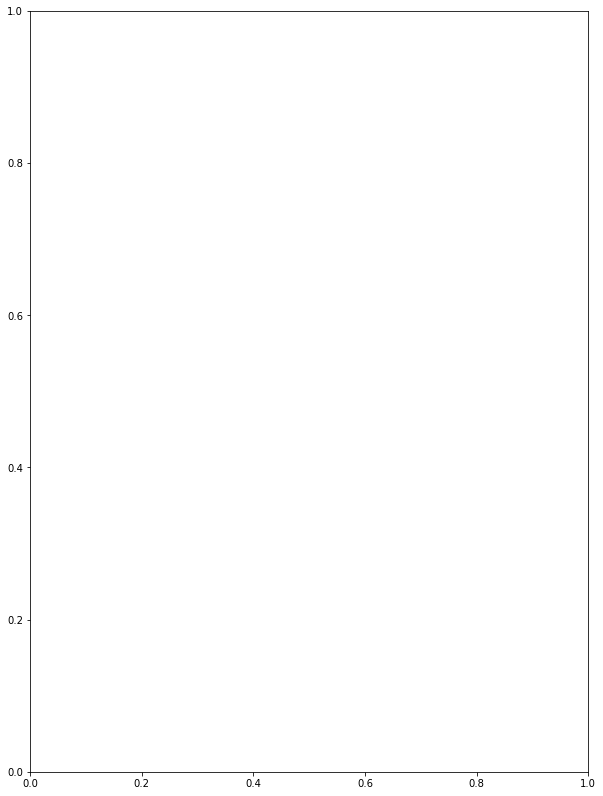

In [17]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))